<a href="https://colab.research.google.com/github/Yoseph-Zuskin/midaspy/blob/master/example/monthly_CPI_daily_stock_index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mixed Frequency Time-Series Forecasting Tutorial Using MIDAS Regression

##### This library is still in alpha stage of development. To install, run the following command:

In [1]:
%matplotlib inline
# Load all necessary packages
import pandas as pd
#import sys
#sys.path.append("../")
#from midaspy.model import MIDASRegressor

#### Use the following functions to extract CSV file from zip files and load data from Statistics Canada:

In [2]:
from zipfile import ZipFile
from requests import get
from io import BytesIO
def extract_zip_from_url(link):
    """
    Extract ZIP from URL
    this function extracts the bytes data from within ZIP files that are found online
    
    Parameters
        link (str): URL link for the ZIP file
        
    Returns
        output (dict): dictionary of zipped files' bytes data
    """
    u=get(link)
    f=BytesIO() 
    f.write(u.content)
    input_zip=ZipFile(f)
    output={i:input_zip.read(i) for i in input_zip.namelist()}
    return output

In [3]:
def load_stats_can_data(pid,low_memory=False):
    """
    Load Statistics Canada Data
    custom function to load data directly from an online zip file into a pandas dataframe
    
    Parameters
        pid (str): product id for the Statistics Canada online data asset
        low_memory (bool): memory setting for the pandas.read_csv function
        
    Returns
        df (pandas.DataFrame): resulting dataframe of all variables from the data asset
    """
    # first extract the zip file from the Statistics Canada website using extract_zip_from_url
    online_zip=extract_zip_from_url('https://www150.statcan.gc.ca/n1/tbl/csv/{}-eng.zip'.format(pid))
    # then load the resulting csv file for the data asset and set the date to datetime64[ns] data type
    df=pd.read_csv(BytesIO(online_zip['{}.csv'.format(pid)]),parse_dates=[0],low_memory=low_memory)
    df=df[df.iloc[:,1]=='Canada'] # filter the data asset to exclude data related to the territories
    variables=list(set(df.iloc[:,3])) # define list of variable types as they appear in the 4th column
    variable_series={} # store each variable series in this temporary dictionary instance
    for v in variables: # iterable over all the variables in this data asset
        series=df[df.iloc[:,3]==v].set_index(df.columns[0]).VALUE # filter dataframe for the variable
        series.rename(v,inplace=True) # rename the series to what Statistics Canada refers to it as
        variable_series[v]=series # store the resulting series in the temporary dictionary instance
    df=pd.DataFrame() # create dataframe to store all combined series
    for v in variables: # iterate over each variable and merge it as this works when pd.concat may fail
        df=pd.merge(right=df,left=variable_series[v],right_index=True,left_index=True,how='outer')
    return df        

### Part 1: Load Raw Data

In [4]:
# Load the Canadian Consumer Price Index data frm Statistics Canada
cpi_df=load_stats_can_data('10100106')
col='Consumer Price Index (CPI) inversely weighted by volatility and is adjusted to exclude the effect of changes in indirect taxes (CPIW) (year-over-year percent change)'
cpi_df=cpi_df[~cpi_df.index.duplicated(keep='first')][col]

In [5]:
# load the S&P/TSX Composite index historical daily data from Yahoo Finance
tsx=pd.read_csv('https://query1.finance.yahoo.com/v7/finance/download/%5EGSPTSE?'+\
                'period1=-315619200&period2={}&interval=1d&events=history'.format(
                (pd.Timestamp.today()-pd.Timestamp("1970-01-01"))//pd.Timedelta('1s')),
               parse_dates=['Date'],index_col=0)

### Part 2: Explore & Process the Data

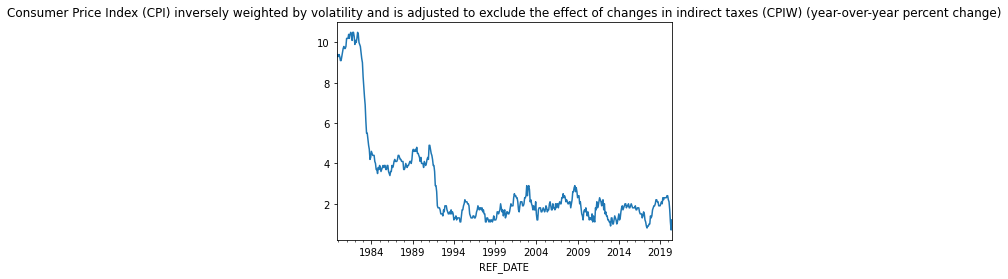

In [6]:
cpi_df.plot(title=col)

In [7]:
# the TSX data exists only for non-holiday weekdays but to keep all months' data comparable
# let's assume that there is no change in economic conditions on those days, so we can forward
# fill missing data over a continuous daily date range to address this issue by first creating
# an empty dataframe of all days in between the start and end dates of the available TSX data
continuous_daterange=pd.date_range(tsx.index[0],tsx.index[-1]).to_frame().drop(0,axis=1)
# then concatenate this continuous date range with the TSX data and do a forward fill
tsx=pd.concat([continuous_daterange,tsx],axis=1).ffill()
del continuous_daterange # delete the temporary continuous_daterange index

In [8]:
# it appears that the volume is zero until November 1984, so only daily data from 1985 onward will be used
tsx[tsx.Volume!=0].dropna().head()

,Open,High,Low,Close,Adj Close,Volume
1984-11-05,2369.100098,2389.800049,2368.800049,2389.800049,2383.731201,112400.0
1984-11-06,2400.899902,2423.000000,2400.899902,2423.000000,2416.846680,161600.0
1984-11-07,2423.899902,2427.000000,2412.899902,2413.800049,2407.670654,105500.0
1984-11-08,2409.399902,2419.100098,2407.199951,2415.199951,2409.066650,90400.0
1984-11-09,2421.100098,2425.800049,2416.199951,2416.500000,2410.363525,75700.0


### Part 3: Fit MIDAS Regressoion Model

In [9]:
x1 = tsx['Adj Close'].rename('TSX_7d_pct_change')['1983-11-01':'2020-06-01'].pct_change(7).dropna()
x2 = tsx['Adj Close'].rename('TSX_14d_pct_change')['1983-11-01':'2020-06-01'].pct_change(14).dropna()
x3 = tsx['Adj Close'].rename('TSX_21d_pct_change')['1983-11-01':'2020-06-01'].pct_change(21).dropna()
x4 = tsx['Adj Close'].rename('TSX_28d_pct_change')['1983-11-01':'2020-06-01'].pct_change(28).dropna()
y = cpi_df.rename('CPI_YoY')['1984-02-01':'2020-06-01']

In [10]:
model = MIDASRegressor(endog=y,exog=pd.concat([x1,x2,x3,x4],axis=1).loc['1983-11-30':],
                       xlag=30,ylag=6,poly='beta')

In [11]:
fit = model.fit() # this may take a few minutes

### Part 4: Evaluate Model Fit

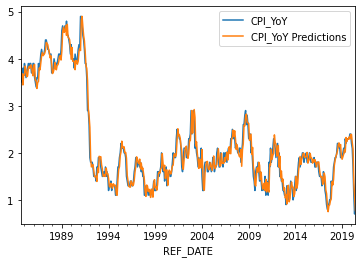

In [12]:
pd.concat([fit.orig_endog,fit.predict()], axis=1).plot()

In [13]:
fit.score()

0.9653730632613234

In [14]:
fit.significance()

,coef,std err,t,P>|t|,0.025,0.975
Constant,0.039,0.023,1.728,0.085,-0.005,0.084
TSX_7d_pct_change,-25.062,5.968,-4.200,0.000,-36.792,-13.332
TSX_14d_pct_change,3.496,0.960,3.644,0.000,1.610,5.382
TSX_21d_pct_change,1.481,0.735,2.016,0.044,0.037,2.925
TSX_28d_pct_change,3.587,0.892,4.021,0.000,1.834,5.341
CPI_YoY t-1,0.909,0.048,18.918,0.000,0.815,1.004
CPI_YoY t-2,0.079,0.066,1.192,0.234,-0.051,0.209
CPI_YoY t-3,0.038,0.066,0.572,0.567,-0.092,0.168
CPI_YoY t-4,0.028,0.066,0.424,0.672,-0.102,0.158
CPI_YoY t-5,0.023,0.066,0.353,0.725,-0.106,0.153
